# Optimisation Implementation
- use scipy.optimisation and just return the inverse which would normally be minimised but by inverting is then maximised when inverted

- optimising with respect to $R_0$

# function

In [1]:
from scipy import exp 

def L(t, k = 0.01):
    """
        Calculates lifetime reproductive output of an organism, 
        as described in Charnov et al. 2001.

        Arguments:
            t {int} -- time
            k {float} -- reproduction senescence
        Returns:
            {float} -- lifetime reproductive output
    """
    return exp(-k*t)


def dRmdt(mR0, t, alpha = 50, M = 1000, a = 2.15, c = 0.17, rho = 0.06, k = 0.01): 
    """
    A function to simulate change in mass and reproductive output for a time point.  
    Function designed with the intention of beign integrated.
    
        Arguments:
        t {float} -- time
        mR0 {float} -- array with mass (g) and reproduction at start of time step 
        alpha {float} -- asymtotic mass (g)
        M {float} -- asymptotic mass (g)
        a {float} -- growth rate (s^-1)
        b {float} -- maintenace cost per cell ## found in function
        c {float} -- reproductive cost (s^-1)
        rho {float} -- scaling factor of reproduction 
        k {float} -- reproductive senesence
        Z {float} -- ## found in function
        
    Returns:
        {scipy.array} -- 
            dmdt --rate of change of mass in grams^1/4 per day (g^1/4 d^-1) at time t
                NOTE:  integration of dmdt will give mass at t
            Rt -- reproductive output at time t in terms of mass 
                NOTE: integration of Rt gives total Reproductive output for the bounds 
                        of the integral
    """
    # predefine outputs 
                
    m = mR0[0] 
    R = mR0[1]
    b = (a/(M**0.25)) -c 
    Z = 2/alpha
    Q = L(t-alpha, k)
    
    # conditional tree dependant on `alpha`
    if t < 0:
        return "ERROR: time < 0"
    if t < alpha:
        dmdt = (a * (m**0.75)) - (b * m)
        R = 0
    elif t >= alpha:
        
        dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
#         R = Q*c * m**rho
        R = c * (exp(-Z)) * m**rho * exp(-(k + Z) * (t - alpha))
    if m + dmdt < 0: # to set `m` to 0 when it would dip below 0
        dmdt = -m
    
    return sc.array([dmdt, R])
#     return dict["dmdt" : dmdt, "Reproduciton" : R]

def Opt(cRho, params): 
    # input vars reordered to suit minimize? with c and rho to be unpacked?
    """
    A function to maximise the function `dRmdt` to give values of `c` and `rho 
    which result in the greatest `R0` possible.
    
    Arguments:
        cRho {list} -- contains the initial guesses for `c` and `rho`;
            c {float} -- reproductive cost (s^-1)
            rho {float} -- scaling factor of reproduction 
            
        params{list} -- contains the parameters needed to run the integration in the order:
        
            t {float} -- time
            mR0 {float} -- array with mass (g) and reproduction at start of time step 
            alpha {float} -- asymtotic mass (g)
            M {float} -- asymptotic mass (g)
            a {float} -- growth rate (s^-1)
            k {float} -- reproductive senesence
            Z {float} -- ## found in function
        
    Returns:
        {array} --  The sum of the reproduction integral for use with `minimise`
        -------the optimal values for `c` and `rho` which yield 
                    the highest cumulative reproduction-----------
        
    """
    # unpack variables
    c, rho = cRho
    t, mR0, alpha, M, a, k = params
    
    # integrate 
    integral = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    # store reproduction
    repro = integral[:,1]
    mass = integral[:,0]
    # sum the integral to have 1 number for optimisation
#     result = sum(repro)
    result = repro[-1]
    
    # to try and avoid shrinking fish 
    if mass[-1] == 0 or mass[-1] < mass[alpha]:
        result = 0
    
    # return negative result since we are minimising 
    return -result
    

In [2]:
## imports
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
from scipy.optimize import minimize

days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 2.15 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
c = 0.1

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
rho = 0.33 # reproductive scaling parameter
k =  0.01

# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]


# exploring output
# mass[-1000:-675] # final 50 values to check for `nan`




plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()


<Figure size 640x480 with 1 Axes>

# Maximisation

In [3]:
import matplotlib.pyplot as plt
########## minimisation #########
c = 0.1
rho = 0.8
cRho = [c, rho]
params = [t, mR0, alpha, M, a, k]

## Sanity check for the opt function
# print(repro[-1])
#     # minus to re-invert as the function is designed to invert with minus for use with optimise
# # print(-Opt(cRho, params)) 
# res_obj = minimize(Opt, cRho, args=(params), method="NELDER-MEAD") 
# print(res_obj)
# c = res_obj.x[0]
# rho = res_obj.x[1]
# params = (alpha, M, a, c, rho, k)
# mR = integrate.odeint(dRmdt, mR0, t, args = params)
# mass = mR[:, 0]
# repro = mR[:, 1]
# plt.figure()
# plt.plot(t, mass, label = "Mass")
# plt.plot(t, repro, label =  "Reproduction")
# plt.xlabel("Time (high resources)")
# plt.ylabel("Mass (high resources)")
# plt.legend()
# plt.show()

# to scan parameter space
ticker = 0
rhoSpace = sc.linspace(0,1,10) # .1 intervals
cSpace = sc.linspace(0, 1, 10)
for i, rho in enumerate(rhoSpace):
    for j, c in enumerate(cSpace):
        # assign c and rho
        cRho = [c, rho]
        params = [t, mR0, alpha, M, a, k]
        # run optimisation
        res_obj = minimize(Opt, cRho, args=(params), method="NELDER-MEAD")
        c = res_obj.x[0]
        rho = res_obj.x[1]
        params = (alpha, M, a, c, rho, k)
        mR = integrate.odeint(dRmdt, mR0, t, args = params)
        mass = mR[:, 0]
        repro = mR[:, 1]
        # if first iteration assign values
        if i == 0 and j == 0:
            OptRepro = repro[-1] 
            Optrho = rho
            Optc = c
        #else compare and assign if better
        if repro[-1] == OptRepro:
            ticker = ticker + 1
        if repro[-1] > OptRepro:
            OptRepro = repro[-1]
            Optrho = rho
            Optc = c 
            OptRes = res_obj
            ticker = 1

            
print(Optc)
print(Optrho)
print("Number of optimal results = ", ticker)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


0.25512924278
0.164934701787
Number of optimal results =  2


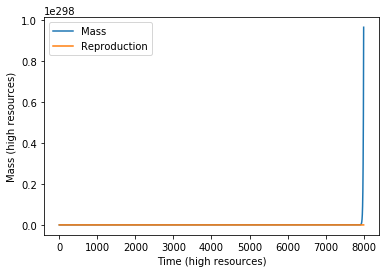

 final_simplex: (array([[ 0.25512924,  0.1649347 ],
       [ 0.25512925,  0.16493468],
       [ 0.25512924,  0.16493472]]), array([ -6.37472818e+14,  -6.37472818e+14,  -6.37472818e+14]))
           fun: -637472817821618.88
       message: 'Optimization terminated successfully.'
          nfev: 131
           nit: 57
        status: 0
       success: True
             x: array([ 0.25512924,  0.1649347 ])

In [4]:
c = Optc
rho = Optrho
params = (alpha, M, a, c, rho, k)
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]
plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()
OptRes

In [5]:
mass[999:1010]

array([  1.49641894e+42,   1.62778619e+42,   1.77068588e+42,
         1.92613040e+42,   2.09522103e+42,   2.27915577e+42,
         2.47923768e+42,   2.69688436e+42,   2.93363774e+42,
         3.19117517e+42,   3.47132128e+42])

since the above yields `nan` below are listed the algorithms which have non-`nan` returns:
- NELDER-MEAD - seems very robust give good results on visual inspection
- POWELL  -  gives `nan` both params
- CG -  gives `nan` both params
- BFGS -  gives `nan` both params


In [6]:
minimize
print(type(mR))
print(mR[alpha,0])
print(mR[-1, 0])
print( mR[-1,0]< mR[alpha, 0])


<class 'numpy.ndarray'>
1.62778619024e+42
9.64210247607e+297
False


In [7]:
if mass[-1] == 0 or mass[-1] < mass[alpha]:
    result = -sc.infty
-result


NameError: name 'result' is not defined

In [ ]:
# sum function for maximise


In [ ]:
minimize(dRmdt, mR0, args = (params), method = 'BFGS')


In [ ]:
minimize

# Testing

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
def func(x):
    return x**2 + 10
def ode(x, t, a=2, b = 2):
    return 2*x + a + b
def odeint(x0, t, a=2, b=2):
    args = (a,b)
    return integrate.odeint(ode, 0, t, args=args)[-1]
def opt (x0, t, a=2, b=2):
    return -odeint(x0, t, a, b)
t = sc.arange(0,100,1)
inter = []
x = sc.linspace(-5, 5, 1000)
y = []
# for i in x:
#     y.append(odeint(i, t))
# a, b =[2,2]
# inter = odeint(x0 = 30, t = t, a=a, b=b)
# # inter = integrate.odeint(ode, 0, t, args=(a,b))
# print(minimize(opt, x0=30, args=(t,a,b)))
# print(minimize(func, x0=30))



# plt.figure()
# plt.plot(x, y)
# plt.show()

# print(minimize(fun = func, x0 = 30))
# print(t)
opt(x, t)

In [ ]:
integrate.odeint
